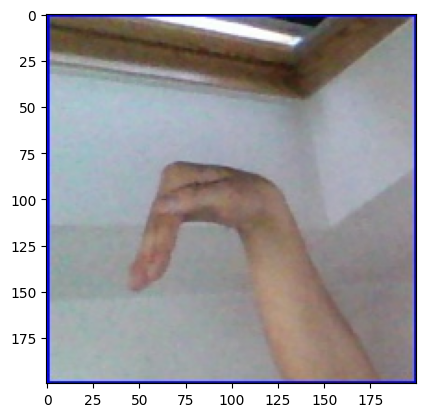

In [10]:
import cv2 as cv
from PIL import Image
import os

import matplotlib.pyplot as plt
import numpy as np

csv_path = 'backend/data/model/keypoints_from_data.csv'
baseData = 'backend/data/archive/asl_alphabet_train/'

sign = 'A'
first = baseData + sign + '/A1.jpg'
imgstmp = []

class SignCategory:
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __str__(self):
        return "<Label: " + self.label + "\n" + str(self.data) + ">"

categories = []
imgsAndLabels = []

for subdir, dir,files in os.walk(baseData):
    if subdir == baseData:
        continue
    
    label = subdir.replace(baseData, '')
    data = []
    
    for idx, file_name in enumerate(files):
        if idx > 250:
            continue
            
        imgPath = subdir + '/' + file_name
        img = np.asarray(Image.open(imgPath))
        data.append(img)

    imgsAndLabels.append((data, label))
    #categories.append(SignCategory(np.array(data), label))

data, label = imgsAndLabels[0]
img1 = data[0]
imgplot = plt.imshow(img1)

Something something, preprocess the thingies like from Video

In [11]:
import copy
import itertools

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [12]:
import mediapipe as mp

use_static_image_mode = 'store_true'
min_detection_confidence = 0.7
min_tracking_confidence = 0.5

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=use_static_image_mode,
    max_num_hands=1,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)


# Mediapipe has seen your hands :eyes:
#results2d = [ hands.process(img) for img in imgs ]

results = []
for data, label in imgsAndLabels:
    for img in data:
        r = ( label, hands.process(img), img )
        results.append( r )


#results = hands.process(img)
#hand_landmarks = results.multi_hand_landmarks
#handedness = results.multi_handedness

print(len(results))
#print(hand_landmarks, "\n-------------------\n", handedness)

I0000 00:00:1707833389.576605  196678 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1707833389.577798  199644 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.2-1pop0~1704238321~22.04~36f1d0e), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


7279


In [13]:
import csv

for label, mediapipe_result, raw_img in results: 
    
    if mediapipe_result.multi_hand_landmarks is not None:
        # Let's spit out the preprocessed landmarks to a CSV for training later.
        for hand_landmarks, handedness in zip(mediapipe_result.multi_hand_landmarks,
                                              mediapipe_result.multi_handedness):
            
            landmark_list = calc_landmark_list(raw_img, hand_landmarks)
            
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            with open(csv_path, 'a', newline="") as f:
                writer = csv.writer(f)
                writer.writerow([label, *pre_processed_landmark_list])



In [14]:
#Training commences

In [15]:
with open(csv_path, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

landmarks_list = []
labels_list = []
for entry in data:
    landmarks_list.append(np.array(entry[1:], dtype=np.float32))
    labels_list.append(entry[0])

landmarks_array = np.array(landmarks_list)
labels_array = np.array(labels_list)

len(labels_array) == len(landmarks_array)

True

In [16]:
from sklearn.model_selection import train_test_split

#Zip landmarks and labels, then shuffle, then unzip
zipped = list(zip(landmarks_array, labels_array))

#then shuffle
train_set, test_set = train_test_split(zipped, test_size=0.2, random_state=42)

landmarks_train = []
labels_train = []
landmarks_test = []
labels_test = []
for landmark, label in train_set:
    landmarks_train.append(landmark)
    labels_train.append(label)
for landmark, label in test_set:
    landmarks_test.append(landmark)
    labels_test.append(label)
landmarks_train = np.array(landmarks_train)
labels_train = np.array(labels_train)
landmarks_test = np.array(landmarks_test)
labels_test = np.array(labels_test)


In [17]:
labels_train_A = (labels_train == 'A')
labels_test_A = (labels_test == 'A')

In [18]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(landmarks_train, labels_train_A)

SGDClassifier(random_state=42)

In [19]:
idx = 55
some_lm = landmarks_array[idx]
some_lm_label = labels_array[idx]

prediction = sgd_clf.predict( [ some_lm ])
print("Label of some_lm: " + some_lm_label + "\tprediction: " + str(prediction))

Label of some_lm: del	prediction: [False]


In [20]:
##
## TIME TO LOOK AT THE STATS
##

from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, landmarks_train, labels_train_A, cv=3, scoring="accuracy")

array([0.99774266, 0.99548533, 0.99699022])

In [21]:
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix

labels_train_pred = cross_val_predict(sgd_clf, landmarks_train, labels_train_A, cv=3)
cm = confusion_matrix(labels_train_A, labels_train_pred)
cm

array([[3832,    9],
       [   4,  142]])

In [22]:
## REcall+ precision
from sklearn.metrics import precision_score, recall_score 

precision = precision_score(labels_train_A, labels_train_pred) 
recall = recall_score(labels_train_A, labels_train_pred)

print(precision, recall)

0.9403973509933775 0.9726027397260274


In [23]:
##
## V OR NOT V
##
from sklearn.ensemble import RandomForestClassifier

labels_train_V = (labels_train == 'V')
labels_test_V = (labels_test == 'V')

sgd_v = SGDClassifier(random_state=42) 
sgd_v.fit(landmarks_train, labels_train_V)

forest_v = RandomForestClassifier(random_state=42)

In [24]:
##
## TIME TO LOOK AT THE STATS FOR V
##
cross_val_score(sgd_v, landmarks_train, labels_train_V, cv=3, scoring="accuracy")

labels_train_pred_v = cross_val_predict(sgd_v, landmarks_train, labels_train_V, cv=3)
cm = confusion_matrix(labels_train_V, labels_train_pred_v)
cm

array([[3816,    3],
       [  10,  158]])

In [25]:
precision_v = precision_score(labels_train_V, labels_train_pred) 
recall_v = recall_score(labels_train_V, labels_train_pred)

print(precision_v, recall_v)

0.0 0.0


In [26]:
## random forest for V
labels_probas_forest_v = cross_val_predict(forest_v, landmarks_train, labels_train_V, cv=3, method="predict_proba")

labels_probas_forest_v[:1000]

array([[1. , 0. ],
       [1. , 0. ],
       [0.7, 0.3],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [27]:
labels_train[2]

'U'

In [60]:
##
## MULTICLASS CLASSIFICATION
##
from sklearn.svm import SVC

sgd_clf_ovo = SGDClassifier(random_state=42) 

#sgd_clf.fit(landmarks_train, labels_train)
sgd_clf_ovo.fit(landmarks_train, labels_train)

SGDClassifier(random_state=42)

In [61]:
cross_val_score(sgd_clf_ovo, landmarks_train, labels_train, cv=3, scoring="accuracy")

array([0.95334838, 0.95485327, 0.92851768])

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
landmarks_train_scaled = scaler.fit_transform(landmarks_train.astype("float64")) 
cross_val_score(sgd_clf_ovo, landmarks_train_scaled, labels_train, cv=3, scoring="accuracy")

array([0.94808126, 0.94732882, 0.95711061])

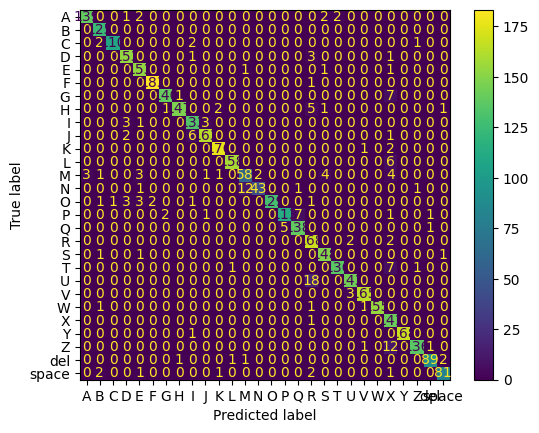

In [63]:
labels_train_predict_ovo = cross_val_predict(sgd_clf_ovo, landmarks_train_scaled, labels_train, cv=3)
ConfusionMatrixDisplay.from_predictions(labels_train, labels_train_predict_ovo)
plt.show()

In [80]:
##
##
##  SOFTMAX ENJOYERS! ##
##
##
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(random_state=42, max_iter = 10_000)
softmax_reg.fit(landmarks_train, labels_train)

LogisticRegression(max_iter=10000, random_state=42)

In [81]:
(softmax_reg.predict( [landmarks_test[0]] ), labels_test[0])

(array(['C'], dtype='<U5'), 'C')

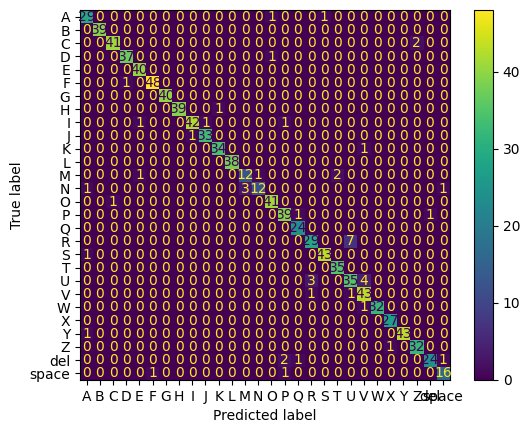

In [82]:
scaler = StandardScaler() 
landmarks_test_scaled = scaler.fit_transform(landmarks_test.astype("float64")) 

labels_train_predict_softmax = cross_val_predict(softmax_reg, landmarks_test_scaled, labels_test, cv=3)
ConfusionMatrixDisplay.from_predictions(labels_test, labels_train_predict_softmax)
plt.show()

In [83]:
from joblib import dump
if False:
    dump(softmax_reg, "backend/data/model/softmax.joblib")    

In [84]:
from sklearn.metrics import classification_report

predictions = softmax_reg.predict(landmarks_test)
predictions_sgd  = sgd_clf_ovo.predict(landmarks_test)

print(classification_report(labels_test, predictions, target_names=softmax_reg.classes_), classification_report(labels_test, predictions_sgd, target_names=sgd_clf_ovo.classes_))

              precision    recall  f1-score   support

           A       0.94      0.97      0.95        31
           B       1.00      1.00      1.00        39
           C       0.98      0.98      0.98        43
           D       1.00      1.00      1.00        38
           E       0.95      1.00      0.98        40
           F       0.98      0.98      0.98        49
           G       1.00      1.00      1.00        40
           H       1.00      1.00      1.00        40
           I       0.98      0.93      0.95        45
           J       0.97      0.97      0.97        34
           K       1.00      0.97      0.99        35
           L       1.00      1.00      1.00        38
           M       0.92      0.69      0.79        16
           N       0.93      0.82      0.88        17
           O       1.00      1.00      1.00        42
           P       0.97      0.95      0.96        41
           Q       0.86      1.00      0.92        24
           R       0.90    

In [96]:
## 
## SOLVERS 
##
##

sm_newtong_cg = LogisticRegression(random_state=42, max_iter = 10_000, solver = "newton-cg")
sm_newtong_cg.fit(landmarks_train, labels_train)

sm_sag = LogisticRegression(random_state=42, max_iter = 10_000, solver = "sag")
sm_sag.fit(landmarks_train, labels_train)

sm_saga = LogisticRegression(random_state=42, max_iter = 10_000, solver = "saga")
sm_saga.fit(landmarks_train, labels_train)

LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [95]:
print("Softmax: lbfgs", classification_report(labels_test, predictions, target_names=softmax_reg.classes_))

preds_newton_cg = sm_newtong_cg.predict(landmarks_train)
preds_sag = sm_sag.predict(landmarks_train)
preds_saga = sm_saga.predict(landmarks_train)

print("Softmax: newton-cg\n", classification_report(labels_test, predictions, target_names=sm_newtong_cg.classes_))
print("Softmax: sag\n", classification_report(labels_test, predictions, target_names=sm_sag.classes_))
print("Softmax: saga\n", classification_report(labels_test, predictions, target_names=sm_saga.classes_))

Softmax: lbfgs               precision    recall  f1-score   support

           A       0.94      0.97      0.95        31
           B       1.00      1.00      1.00        39
           C       0.98      0.98      0.98        43
           D       1.00      1.00      1.00        38
           E       0.95      1.00      0.98        40
           F       0.98      0.98      0.98        49
           G       1.00      1.00      1.00        40
           H       1.00      1.00      1.00        40
           I       0.98      0.93      0.95        45
           J       0.97      0.97      0.97        34
           K       1.00      0.97      0.99        35
           L       1.00      1.00      1.00        38
           M       0.92      0.69      0.79        16
           N       0.93      0.82      0.88        17
           O       1.00      1.00      1.00        42
           P       0.97      0.95      0.96        41
           Q       0.86      1.00      0.92        24
           R